In [1]:
ROOT = '../dataset/'

DATASET = 'environmental'
# DATASET = 'character'
# DATASET = 'mech'
# DATASET = 'icons'
# DATASET = 'waifu'
# DATASET = 'propaganda-poster'

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sys
import json
import glob
import torch

from io import BytesIO

import numpy as np
import pandas as pd

from PIL import Image
from matplotlib import pyplot

import msgpack

from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
DATA_PATH = f'data/{DATASET}/data.json'

WEIGHT_PATH = os.path.join('weight/072', DATASET, 'clip_image_embeds.pt')

# load rank data

In [7]:
paths = sorted(glob.glob(os.path.join(ROOT, 'ranking', DATASET, '*.json')))

rank_file_paths = list()
rank_pairs = list()

for path in tqdm(paths, leave=False):
    js = json.load(open(path))

    if js['task'] != 'selection':
        continue
    
    file_path_1 = os.path.splitext(js['image_1_metadata']['file_path'])[0].replace('datasets/', '')
    file_path_2 = os.path.splitext(js['image_2_metadata']['file_path'])[0].replace('datasets/', '')

    if not os.path.exists(os.path.join(ROOT, 'clip', f'{file_path_1}_clip.msgpack')):
        continue
    if not os.path.exists(os.path.join(ROOT, 'clip', f'{file_path_2}_clip.msgpack')):
        continue
        
    rank_file_paths.append(path)
    rank_pairs.append((file_path_1, file_path_2, js['selected_image_index']))

  0%|          | 0/127639 [00:00<?, ?it/s]

In [8]:
rank_pairs = pd.DataFrame(rank_pairs, columns=['image_1', 'image_2', 'selected_image_index'])

# load emb

In [12]:
file_paths = list(set(list(rank_pairs['image_1']) + list(rank_pairs['image_2'])))

sample_embeds = list()

for file_path in tqdm(file_paths, total=len(file_paths), leave=False):

    path = os.path.join(ROOT, 'clip', f'{file_path}_clip.msgpack')
    with open(path, 'rb') as f:
        mp = msgpack.load(f)
    sample_embeds.append(np.array(mp['clip-feature-vector']))

path_to_index = {file_path: i for i, file_path in enumerate(file_paths)}

sample_embeds = np.concatenate(sample_embeds, axis=0)

  0%|          | 0/103131 [00:00<?, ?it/s]

# build dataset

In [13]:
ordered_pairs = [((image_1, image_2) if selected_image_index == 0 else (image_2, image_1)) for image_1, image_2, selected_image_index in rank_pairs.itertuples(index=False, name=None)]
ordered_pairs = pd.DataFrame(ordered_pairs, columns=['image_1', 'image_2'])

ordered_pairs['index_1'] = ordered_pairs['image_1'].apply(path_to_index.get)
ordered_pairs['index_2'] = ordered_pairs['image_2'].apply(path_to_index.get)
ordered_pairs['file_path'] = [i.replace(f'{ROOT}ranking/{DATASET}/', f'datasets/{DATASET}/data/ranking/aggregate/') for i in rank_file_paths]

## build feature

In [14]:
train_indices, val_indices = train_test_split(ordered_pairs.index, test_size=0.2, random_state=42)

In [15]:
train_data = list()
for index_1, index_2 in ordered_pairs.loc[train_indices, ['index_1', 'index_2']].itertuples(index=False, name=None):
    train_data.append(np.stack([sample_embeds[index_1], sample_embeds[index_2]], axis=-1))
train_data = np.stack(train_data, axis=0)

val_data = list()
for index_1, index_2 in ordered_pairs.loc[val_indices, ['index_1', 'index_2']].itertuples(index=False, name=None):
    val_data.append(np.stack([sample_embeds[index_1], sample_embeds[index_2]], axis=-1))
val_data = np.stack(val_data, axis=0)

train_data.shape, val_data.shape

((101510, 768, 2), (25378, 768, 2))

In [16]:
train_dataset = torch.tensor(train_data).cuda().float()
val_dataset = torch.tensor(val_data).cuda().float()

# build model

In [17]:
# model = torch.nn.Linear(train_data.shape[1], 1, bias=True)
model = torch.nn.Linear(train_data.shape[1], 16, bias=True)
# model = torch.nn.Sequential(
#     torch.nn.Linear(train_data.shape[1], 16, bias=True),
#     torch.nn.AdaptiveMaxPool1d(1),
#     torch.nn.ReLU(),
#     torch.nn.Linear(16, 16, bias=True),
#     torch.nn.ReLU(),
#     torch.nn.Linear(16, 1, bias=True)
# )
model = model.cuda()

# train model

In [18]:
LR = 1e-3

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-3)

In [19]:
bces, accs = list(), list()

for epoch in tqdm(range(1000)):
    
    model.train()
    
    label = torch.zeros((train_dataset.shape[0],), device='cuda')
    # label = torch.zeros((train_dataset.shape[0] * 16,), device='cuda')
    
    x = train_dataset

    optimizer.zero_grad()

    y0s = model(x[..., 0])
    y0 = y0s.max(dim=-1, keepdims=True).values
    # y0 = y0s.reshape(-1, 1)
    y1s = model(x[..., 1])
    y1 = y1s.max(dim=-1, keepdims=True).values
    # y1 = y1s.reshape(-1, 1)

    y = torch.concat([y0, y1], dim=-1)

    # backward

    bce = torch.nn.functional.cross_entropy(y, label.long())

    acc = (y0 > y1).float().mean()

    l1 = torch.norm(model.weight, p=1)

    loss = bce + l1 * 1e-3
    
    # diversity
    
    diversity = ((y0s.mean(dim=0, keepdims=True) - y0s.mean(dim=0, keepdims=True).T) ** 2).mean()
    diversity += ((y1s.mean(dim=0, keepdims=True) - y1s.mean(dim=0, keepdims=True).T) ** 2).mean()
    loss += diversity

    # orthogonality

    weight = torch.nn.functional.normalize(model.weight, p=2, dim=1)
    dot_product_matrix = torch.matmul(weight, weight.t())
    dot_product_matrix = dot_product_matrix.fill_diagonal_(0.)
    orthogonality = (dot_product_matrix ** 2).mean()
    loss += orthogonality

    loss.backward()
    optimizer.step()

    # warmup.step()

    bces.append(bce.detach().cpu().numpy())
    accs.append(acc.detach().cpu().numpy())
        
    if (epoch + 1) % 100 == 0:
        
        model.eval()

        val_bces, val_accs = list(), list()

        with torch.no_grad():
            
            x = val_dataset

            with torch.cuda.amp.autocast(True):

                y0s = model(x[..., 0])
                y0 = y0s.max(dim=-1, keepdims=True).values
                y1s = model(x[..., 1])
                y1 = y1s.max(dim=-1, keepdims=True).values

                y = torch.concat([y0, y1], dim=-1)

            label = torch.zeros((y.shape[0],), device='cuda').long()

            bce = torch.nn.functional.cross_entropy(y, label)

            acc = (y.argmax(dim=-1) == 0).float().mean()

            val_bces.append(bce.detach().cpu().numpy())
            val_accs.append(acc.detach().cpu().numpy())

        print(f'{np.mean(bces):.4f} {np.mean(accs):.4f} {np.mean(val_bces):.4f} {np.mean(val_accs):.4f}')
    
        bces, accs = list(), list()

  0%|          | 0/1000 [00:00<?, ?it/s]

0.4077 0.8424 0.3467 0.8739
0.3335 0.8828 0.3323 0.8785
0.3213 0.8857 0.3218 0.8810
0.3124 0.8868 0.3140 0.8822
0.3062 0.8878 0.3088 0.8832
0.3017 0.8888 0.3052 0.8840
0.2985 0.8895 0.3025 0.8844
0.2961 0.8905 0.3003 0.8845
0.2942 0.8910 0.2988 0.8845
0.2927 0.8912 0.2979 0.8847


## calculate score

In [20]:
with torch.no_grad():
    # with torch.cuda.amp.autocast(True):
        # scores = model(torch.tensor(sample_embeds).half().cuda())
        scores = model(torch.tensor(sample_embeds).float().cuda())
        scores = scores.detach().cpu().numpy().astype('float32')
        score = np.max(scores, axis=-1)
        max_score_id = np.argmax(scores, axis=-1)

In [22]:
np.unique(max_score_id, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([ 2051, 19563,  1931,  2010,  1771,  1887,  2795,  1642,  1490,
        12440,  2576, 46093,  1745,  2133,  1867,  1137]))

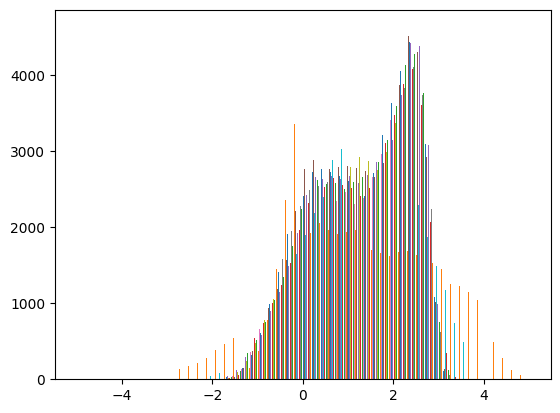

In [23]:
_ = pyplot.hist(scores, bins=100, range=(-5., 5.))

In [24]:
score_mean, score_std = score.mean(axis=0), score.std(axis=0)
sigma_score = (score - score_mean[None]) / score_std[None]

In [25]:
ordered_pairs['sigma_score_1'] = sigma_score[ordered_pairs['index_1']]
ordered_pairs['sigma_score_2'] = sigma_score[ordered_pairs['index_2']]
ordered_pairs['predicted_proba'] = torch.softmax(torch.tensor(np.stack([
    score[ordered_pairs['index_1']],
    score[ordered_pairs['index_2']],
], axis=-1)), dim=-1)[..., 0].detach().cpu().numpy()
ordered_pairs['max_score_id_1'] = max_score_id[ordered_pairs['index_1']]
ordered_pairs['max_score_id_2'] = max_score_id[ordered_pairs['index_2']]

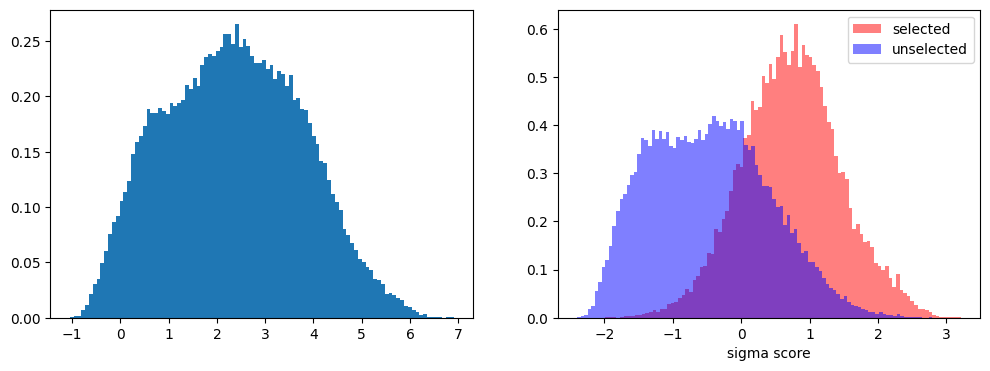

In [26]:
pyplot.figure(figsize=(12, 4))

pyplot.subplot(1, 2, 1)

_ = pyplot.hist(score, bins=100, density=True)

pyplot.subplot(1, 2, 2)

_ = pyplot.hist(ordered_pairs['sigma_score_1'].values, bins=100, density=True, alpha=0.5, color='r', label='selected')
_ = pyplot.hist(ordered_pairs['sigma_score_2'].values, bins=100, density=True, alpha=0.5, color='b', label='unselected')
pyplot.xlabel('sigma score')
pyplot.legend()

# save model

In [21]:
os.makedirs(os.path.split(WEIGHT_PATH)[0], exist_ok=True)
torch.save(model.state_dict(), WEIGHT_PATH)
np.savez(
    WEIGHT_PATH.replace('.pt', '.npz'), 
    mean=score_mean,
    std=score_std,
)

# check

In [27]:
# MINIO_ADDRESS = "123.176.98.90:9000"
MINIO_ADDRESS = "192.168.3.5:9000"
access_key = "GXvqLWtthELCaROPITOG"
secret_key = "DmlKgey5u0DnMHP30Vg7rkLT0NNbNIGaM8IwPckD"
bucket_name = 'datasets'

In [28]:
sys.path.append(os.path.abspath('../kcg-ml-image-pipeline/'))

from utility.minio.cmd import connect_to_minio_client

In [29]:
client = connect_to_minio_client(MINIO_ADDRESS, access_key, secret_key)

Connecting to minio client...
Successfully connected to minio client...


In [30]:
def get_image_by_path(file_path):
    
    data = client.get_object(bucket_name=bucket_name, object_name=f'{file_path}.jpg')

    return Image.open(BytesIO(data.data))

def show_images(file_paths):

    num_rows = max(1, int(np.floor(len(file_paths) ** 0.5)))
    file_paths = file_paths[:num_rows * num_rows]

    target_size = 1024 // num_rows

    images = list()
    for file_path in tqdm(file_paths, leave=False):
        img = get_image_by_path(file_path)
        images.append(np.array(img.resize((target_size, target_size))))

    images = np.stack(images)
    images = images.reshape(num_rows, num_rows, target_size, target_size, 3)
    images = np.concatenate(np.concatenate(images, axis=-3), axis=-2)
    return Image.fromarray(images)

def show_pairs(file_paths_1, file_paths_2):

    n = len(file_paths_1)

    target_size = 1024 // n

    images_1 = list()
    for file_path in tqdm(file_paths_1, leave=False):
        img = get_image_by_path(file_path)
        images_1.append(np.array(img.resize((target_size, target_size))))

    images_1 = np.stack(images_1)
    images_1 = np.concatenate(images_1, axis=-2)

    images_2 = list()
    for file_path in tqdm(file_paths_2, leave=False):
        img = get_image_by_path(file_path)
        images_2.append(np.array(img.resize((target_size, target_size))))

    images_2 = np.stack(images_2)
    images_2 = np.concatenate(images_2, axis=-2)

    images = np.concatenate([images_1, images_2], axis=-3)
    
    return Image.fromarray(images)

  0%|          | 0/16 [00:00<?, ?it/s]

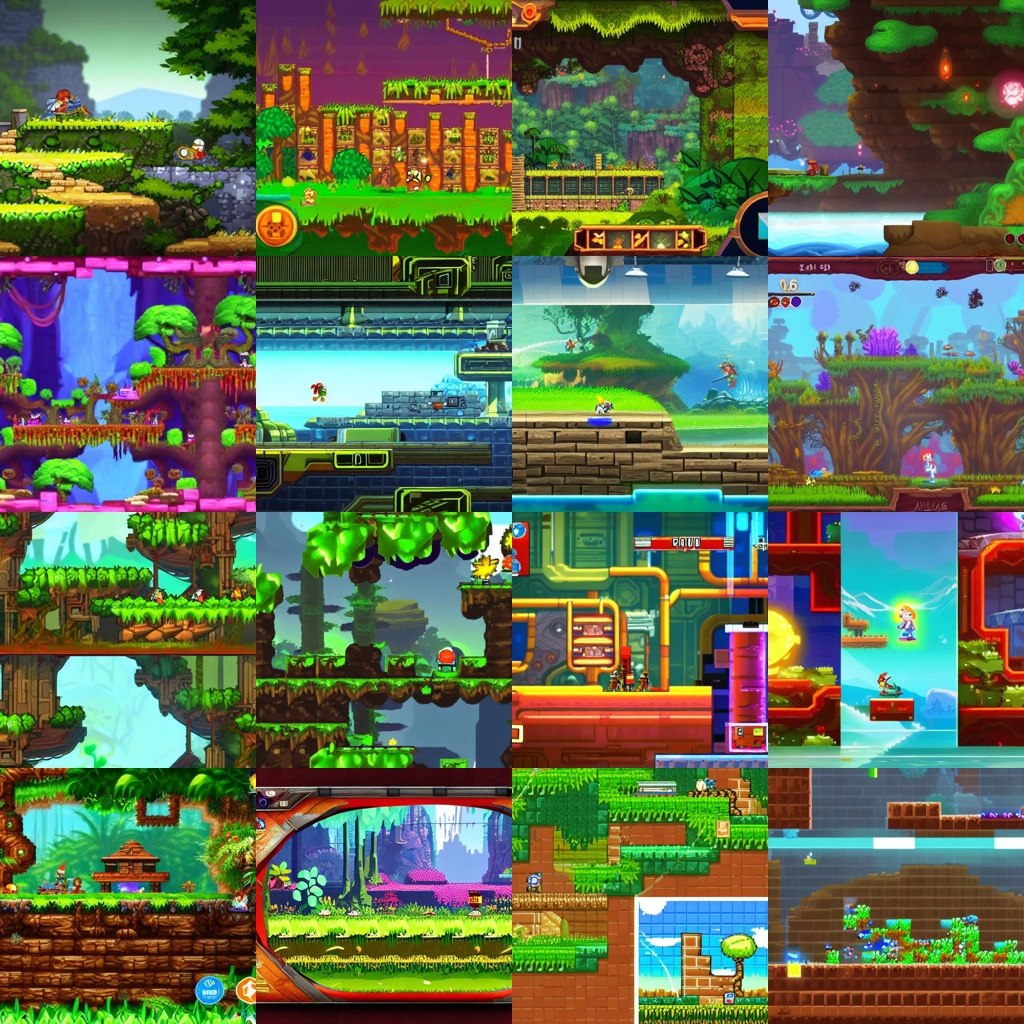

In [31]:
# show_images(ordered_pairs.sort_values('sigma_score_2')['image_2'].drop_duplicates().iloc[:16])
show_images(ordered_pairs.query('max_score_id_1 == 12').sort_values('sigma_score_1', ascending=False)['image_1'].drop_duplicates().iloc[:16])

## check pairs

In [37]:
# selected = ordered_pairs.query('(sigma_score_1 - sigma_score_2 < -2) and sigma_score_2 > 1')
selected = ordered_pairs.sort_values('predicted_proba')
selected[['image_1', 'image_2', 'file_path', 'sigma_score_1', 'sigma_score_2', 'predicted_proba']].head(8)

,image_1,image_2,file_path,sigma_score_1,sigma_score_2,predicted_proba
4803,environmental/0010/009526,environmental/0007/006795,datasets/environmental/data/ranking/aggregate/...,-1.781546,1.590785,0.000069
42721,environmental/0016/015093,environmental/0006/005258,datasets/environmental/data/ranking/aggregate/...,-1.955031,1.318638,0.000091
4815,environmental/0022/021670,environmental/0017/016067,datasets/environmental/data/ranking/aggregate/...,-1.852288,1.115215,0.000217
5609,environmental/0001/000027,environmental/0016/015151,datasets/environmental/data/ranking/aggregate/...,-2.459121,0.202560,0.000518
7448,environmental/0019/018159,environmental/0011/010864,datasets/environmental/data/ranking/aggregate/...,-1.014542,1.538555,0.000706
7248,environmental/0024/023276,environmental/0006/005962,datasets/environmental/data/ranking/aggregate/...,-1.358163,1.178441,0.000739
5412,environmental/0019/018733,environmental/0017/016985,datasets/environmental/data/ranking/aggregate/...,-0.844107,1.472580,0.001380
8172,environmental/0017/016894,environmental/0007/006375,datasets/environmental/data/ranking/aggregate/...,-1.380326,0.889800,0.001575


  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

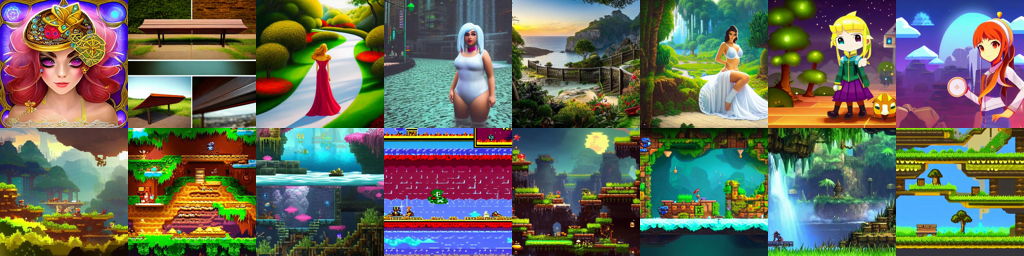

In [36]:
show_pairs(selected['image_1'][:8], selected['image_2'][:8])